In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import copy
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import f1_score

from mlxtend.feature_selection import ColumnSelector
import missingno as msno
import arfs.allrelevant as arfsgroot

from lightgbm import LGBMClassifier
from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline 

import optuna
import gc
import sys

from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

pd.set_option('max_rows', 200)
pd.set_option('max_colwidth', 200)

In [2]:
def get_grid_result(gridsearch_name):    
    result = (
        pd.DataFrame({
            'mean_f1': gridsearch_name.cv_results_['mean_test_f1'],
            'mean_average_precision': gridsearch_name.cv_results_['mean_test_average_precision'],
            'mean_roc_auc': gridsearch_name.cv_results_['mean_test_roc_auc']}).join(
        pd.json_normalize(gridsearch_name.cv_results_['params']).add_prefix('param_'))
    ).sort_values(['mean_average_precision'], ascending = False)
         
    return result

def get_indexes_features(dataframe, features):
    indexes = [dataframe.columns.get_loc(feature) for feature in features]
    return indexes

def print_data_plots(dataframe):
    
    columns_countplot = [column for column in dataframe.columns if dataframe[column].nunique() < 80]
    columns_distplot = [column for column in dataframe.columns if dataframe[column].nunique() > 80]
    fig_dims = (13,4)    
    
    for column in dataframe[columns_countplot].columns:
        plt.figure()
        fig, ax = plt.subplots(figsize=fig_dims) 
        #fig.autofmt_xdate()
        sns.countplot(x=column, data=dataframe)
        
    for column in dataframe[columns_distplot].columns:
        plt.figure()
        fig, ax = plt.subplots(figsize=fig_dims) 
        #fig.autofmt_xdate()
        sns.histplot(dataframe[column])

# функция из imbalanced-learn для использования IsolationForest в пайплайне        
def reject_outliers(X, y, contamination=0.01):
    
    model = IsolationForest(contamination=contamination, random_state=42, n_jobs=-1)
    model.fit(X)
    y_pred = model.predict(X)
    
    return X[y_pred == 1], y[y_pred == 1]

# две функции ниже из статьи для отображения объектов и занимаемого ими места
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v) for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

In [3]:
df = pd.read_csv('train.csv', sep = ',')
df_test = pd.read_csv('sample_submission.csv', sep = ',')

In [4]:
df_test.head(5)

id  target
0  0;133       0
1    0;5       1
2   0;10       0
3  0;396       1
4   0;14       0

In [5]:
df.head(5)

user_id   order_completed_at  cart
0        2  2015-03-22 09:25:46   399
1        2  2015-03-22 09:25:46    14
2        2  2015-03-22 09:25:46   198
3        2  2015-03-22 09:25:46    88
4        2  2015-03-22 09:25:46   157

In [6]:
# готовим тестовые данные для соединения с обучающими для генерации признаков
df_test_sp = df_test.id.str.split(pat = ";", expand=True)
df_test_sp = pd.concat([df_test_sp, df_test.target], axis = 1)
df_test_sp.rename(columns={0: "user_id", 1: "cart", 'target': 'y'}, inplace = True)
df_test_sp['date']  = pd.Timestamp('2022-03-22 01:01:01')
df_test_sp.user_id = df_test_sp.user_id.astype('int64')
df_test_sp.cart = df_test_sp.cart.astype('int64')

df.rename(columns={"order_completed_at": "date"}, inplace = True)
df["date"] = pd.to_datetime(df["date"],format='%Y-%m-%d %H:%M:%S')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column   Dtype         
---  ------   -----         
 0   user_id  int64         
 1   date     datetime64[ns]
 2   cart     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


In [8]:
df_test_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   user_id  790449 non-null  int64         
 1   cart     790449 non-null  int64         
 2   y        790449 non-null  int64         
 3   date     790449 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 24.1 MB


In [9]:
df.agg(['nunique'])

user_id    date  cart
nunique    20000  208155   881

In [10]:
df_test_sp.agg(['nunique'])

user_id  cart  y  date
nunique    13036   858  2     1

In [11]:
# нумеруезм заказы пользователей, начиная с первого для EDA
df.sort_values(by=['user_id',"date"], inplace = True)
order_num = df.groupby('user_id')['date'].apply(lambda x: LabelEncoder().fit_transform(x)).explode()
order_num.reset_index(drop=True, inplace = True)
order_num.rename('order_num', inplace = True)
df.reset_index(drop=True, inplace = True)
df_ord_num = pd.concat([df, order_num], axis=1)
df_ord_num.order_num += 1
df_ord_num.sort_values(by=['date'], inplace = True)

In [12]:
# смотрим какое количество пользователей сделали какое количество заказов
# для создания признаков на основе временого ряда важно знать сколько пользователей сделали сколько заказов,
# потому что, если признак основывается на данных много временных шагов назад, то за эти шаги значение признака
# будет NaN, удаляя объекты с таким значением по одному признаку модно потерять много данных
users_per_order = df_ord_num.groupby(['user_id','order_num']).size().to_frame()
users_per_order.reset_index(inplace = True)
users_per_order['order_num'].value_counts().to_frame().head(20)

order_num
1       20000
3       20000
2       20000
4       15962
5       13229
6       11203
7        9680
8        8451
9        7436
10       6601
11       5925
12       5357
13       4854
14       4404
15       4001
16       3633
17       3290
18       3021
19       2787
20       2552

In [13]:
# смотрим какое количество пользователей сделали какое максимальное количество заказов
# как видно большинство пользователей сделали не так много покупок и признаки, описанные выше,
# скорее всего, лучше не создавать
users_per_order2 = users_per_order.groupby(['user_id'])['order_num'].max().to_frame()
users_per_order2.value_counts().to_frame().head(20)

0
order_num      
3          4038
4          2733
5          2026
6          1523
7          1229
8          1015
9           835
10          676
11          568
12          503
13          450
14          403
15          368
16          343
17          269
19          235
18          234
20          206
21          187
22          157

<AxesSubplot:xlabel='order_num', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

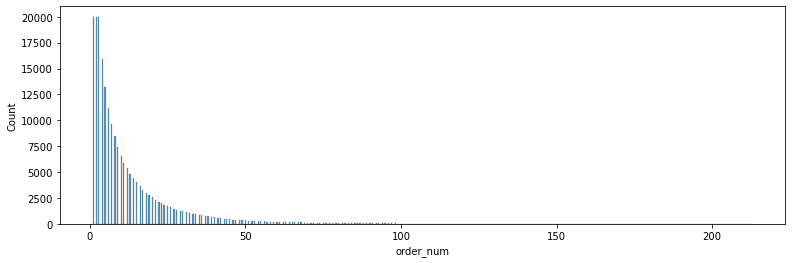

In [14]:
# смотрим какое количество пользователей сделали какое количество заказов
fig_dims = (13,4)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims) 
sns.histplot(users_per_order['order_num'])

<AxesSubplot:xlabel='date', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

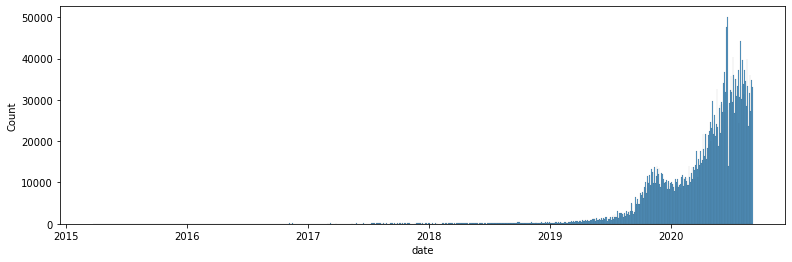

In [15]:
# количество категорий (товаров) заказанное пользователями во времени
# стоит попробовать обучить модель как на полном датасете, так и на датасете 
# с данными, начиная с 2019 года, так как значения признаков за период ранее
# могут быть экстримальными, обучение на них может понизить качество предсказания
# в реалях конца 2020 года
# если отталкиваться от того что это данные Instamart(сбермаркет) то перименование, 
# открытие новых магазинов и, навреное, выпуск нового приложения произошли осенью 2019
# значение признаков за период ранее также могут быть немного другими

fig_dims = (13,4)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims) 
sns.histplot(df.date)

<AxesSubplot:xlabel='date', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

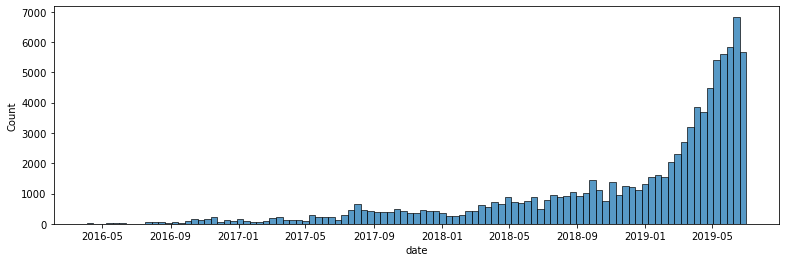

In [16]:
fig_dims = (13,4)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims) 
sns.histplot(df[df.date.between('2016','2019-07')].date)

In [17]:
# пользователей и категорий за данные период не так много
df_ord_num[df_ord_num.date.between('2014','2019')].agg(['nunique'])

user_id  date  cart  order_num
nunique      424  2422   399        100

In [18]:
# возможно несколько товаров перестали выпускать после 2019 года
df_ord_num[df_ord_num.date.between('2019','2021')].agg(['nunique'])

user_id    date  cart  order_num
nunique    20000  205733   876        213

<AxesSubplot:xlabel='cart', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

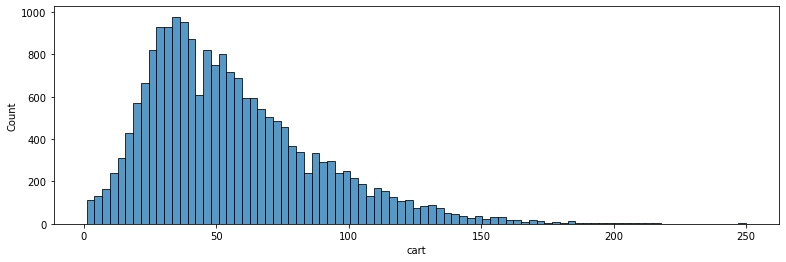

In [19]:
# смотрим какое количество пользователей заказывали какое количество наименований товаров
fig_dims = (13,4)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(df.groupby('user_id').cart.nunique())

<AxesSubplot:xlabel='cart', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

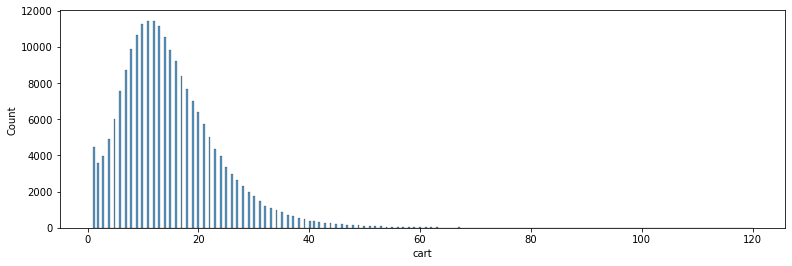

In [20]:
# количество категорий в заказах
fig_dims = (13,4)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims) 
sns.histplot(df_ord_num.groupby(['user_id', 'order_num']).cart.count())

<AxesSubplot:xlabel='cart', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

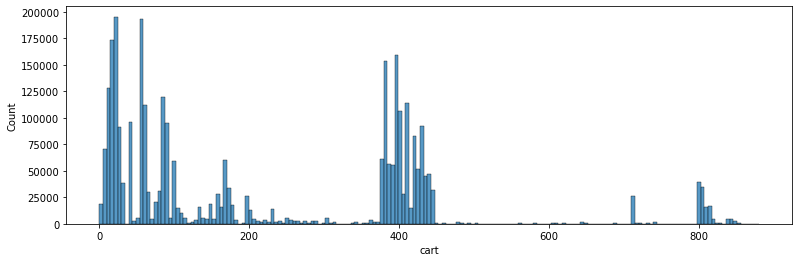

In [21]:
# около половины товаров продается очень редко
fig_dims = (13,4)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(df.cart)

In [22]:
# создаем обучающие примеры отрицательного класса 

products_dates = df.groupby(['user_id', 'date']).cart

# создаем список заказов каждого клиента
# каждый заказ будет содержать товары как с данного заказа (положительные)
# так и все незаказанные вновь товары с предыдущих заказов пользователя (отрицательные)
prev_user_id = 0
all_carts = []
all_orders = []
for group_name, group in products_dates:
    if prev_user_id == group_name[0]:          
        all_carts.extend(list(group))
        all_orders.append(list(set(all_carts))[:])
    else:
        all_carts = []
        all_carts.extend(list(group))
        all_orders.append(list(set(all_carts))[:])
    prev_user_id = group_name[0]
    
# список с категориями которые заказывали в каждом заказе
# спискок с количеством категорий в заказе
now_orders = []
order_size = []
for group_name, group in products_dates:        
        now_orders.append(list(group))  
        order_size.append(len(group))        
        
# категории которые раньше заказывали, но в этом заказе не заказали
negative_products = []
for all_cart, now_cart in zip(all_orders, now_orders):
    negative_products.append(list(set(all_cart).difference(set(now_cart))))
    
# количество товаров, которые не купили  
num_products = []
for product in negative_products:
    num_products.append(len(product))
num_products = np.asarray(num_products)

# составляем списки всех пользователей и дат
group_user_date = df.groupby(['user_id', 'date']).size()
group_user_date = group_user_date.to_frame().reset_index() #####
users = group_user_date.user_id.to_numpy()
dates = group_user_date.date.to_numpy()

# создаем датафрейм с отрицательными примерами
neg_df_dict = {'user_id': np.repeat(users, num_products), 
               'date': np.repeat(dates, num_products),
               'cart': list(itertools.chain.from_iterable(negative_products)),
               'order_size': np.repeat(order_size, num_products)} 
     
neg_df = pd.DataFrame(data=neg_df_dict)
neg_df['y'] = 0
neg_df.head()

user_id                date  cart  order_size  y
0        0 2020-08-24 08:55:32    20          25  0
1        0 2020-08-24 08:55:32   430          25  0
2        0 2020-09-02 07:38:25     5          11  0
3        0 2020-09-02 07:38:25   133          11  0
4        0 2020-09-02 07:38:25    10          11  0

In [23]:
# добавляем размер заказа для положительных примеров
df.sort_values(by=['user_id','date'], inplace = True)
df['order_size']= np.repeat(order_size, order_size)

# добавляем метку класса для положительных примеров
df['y'] = 1

# положительные, отрицательные примеры и тестовые данные для генерации признаков
df = pd.concat([df, neg_df, df_test_sp], ignore_index = True)
df.sort_values(by=['user_id','date'], inplace = True)

In [24]:
user_order_size = df.groupby(['user_id', 'date']).order_size.mean().to_frame()
# рассчитываем средний размер заказа каждого пользователя
mean_order_size = user_order_size.groupby('user_id').expanding().mean().order_size
mean_order_size = mean_order_size.groupby('user_id').shift().values
expanded_order_size = df.groupby(['user_id', 'date']).size().values
df['mean_order_size'] = np.repeat(mean_order_size, expanded_order_size)

In [25]:
# считаем количество дней между заказами для каждого пользователя
df.sort_values(by=['user_id','date','cart'], inplace = True)
df['date2'] = df['date'].dt.date
days_bt_orders = df.groupby(['user_id','date']).date2.unique().explode()
days_bt_orders = days_bt_orders.groupby('user_id').diff() / 1.0 / np.timedelta64(1, 'D')
df['days_bt_orders'] = np.repeat(days_bt_orders.values, expanded_order_size)

# считаем количество дней между последним заказом и последним заказом данного продукта
df['user_days_last_to_product_order'] = 0
df.loc[df['y'] == 0, 'user_days_last_to_product_order'] = df.loc[df['y'] == 0, 'days_bt_orders']
df.loc[df['y'] == 0, 'user_days_last_to_product_order'] = df.loc[df['y'] == 0].groupby(['user_id', 'cart']).user_days_last_to_product_order.cumsum()
df['user_days_last_to_product_order'] = df.groupby(['user_id', 'cart']).user_days_last_to_product_order.shift()
df.sort_values(by=['user_id','cart', 'date'], inplace = True)
df.head(6)

user_id                date  cart  order_size  y  mean_order_size  \
9               0 2020-08-24 08:55:32     5        25.0  1         8.000000   
3123066         0 2020-09-02 07:38:25     5        11.0  0        16.500000   
12171846        0 2022-03-22 01:01:01     5         NaN  1        14.666667   
11              0 2020-08-24 08:55:32    10        25.0  1         8.000000   
3123068         0 2020-09-02 07:38:25    10        11.0  0        16.500000   
12171847        0 2022-03-22 01:01:01    10         NaN  0        14.666667   

               date2  days_bt_orders  user_days_last_to_product_order  
9         2020-08-24            36.0                              NaN  
3123066   2020-09-02             9.0                              0.0  
12171846  2022-03-22           566.0                              9.0  
11        2020-08-24            36.0                              NaN  
3123068   2020-09-02             9.0                              0.0  
12171847  2022-03-22           566.0                              9.0

In [26]:
# считем максимальную длину серии из единиц,
# то есть количество поряд идущих покупок товара
# или отсутсвия покупок (нулей)
df.sort_values(by=['user_id','cart','date'], inplace = True)
df['series'] = df.groupby(['user_id','cart',(df['y'] != df['y'].shift(1)).cumsum()]).cumcount()+1
df['max_length_serie_zeros'] = 0
df['max_length_serie_ones'] = 0
df.loc[df['y'] == 0, 'max_length_serie_zeros'] = df.loc[df['y'] == 0, 'series']
df.loc[df['y'] == 1, 'max_length_serie_ones'] = df.loc[df['y'] == 1, 'series']
# считаем сколько заказов было сделано между последним заказом и последним заказом данного продукта
df['user_orders_last_to_product_order'] = df.groupby(['user_id','cart']).max_length_serie_zeros.shift()
# максимальный размер серии покупк единиц или нулей без покупок для каждого товара понятно все для прелыдущей покупки
df['max_length_serie_zeros'] = df.groupby(['user_id','cart']).max_length_serie_zeros.cummax()
df['max_length_serie_zeros'] = df.groupby(['user_id','cart']).max_length_serie_zeros.shift()
df['max_length_serie_ones'] = df.groupby(['user_id','cart']).max_length_serie_ones.cummax()
df['max_length_serie_ones'] = df.groupby(['user_id','cart']).max_length_serie_ones.shift()

In [27]:
# нумеруем заказы пользователей, начиная с первого
df.sort_values(by=['user_id','date'], inplace = True)
orders = df.groupby('user_id')['date'].apply(lambda x: LabelEncoder().fit_transform(x)).explode()
orders.reset_index(drop=True, inplace = True)
orders.rename('orders', inplace = True)
df.reset_index(drop=True, inplace = True)
df['orders'] = orders
df['order_num'] = df['orders'] + 1

In [28]:
df.head(10)

user_id                date  cart  order_size  y  mean_order_size  \
0        0 2020-07-19 09:59:17    14         8.0  1              NaN   
1        0 2020-07-19 09:59:17    20         8.0  1              NaN   
2        0 2020-07-19 09:59:17    57         8.0  1              NaN   
3        0 2020-07-19 09:59:17    82         8.0  1              NaN   
4        0 2020-07-19 09:59:17   379         8.0  1              NaN   
5        0 2020-07-19 09:59:17   405         8.0  1              NaN   
6        0 2020-07-19 09:59:17   430         8.0  1              NaN   
7        0 2020-07-19 09:59:17   441         8.0  1              NaN   
8        0 2020-08-24 08:55:32     5        25.0  1              8.0   
9        0 2020-08-24 08:55:32    10        25.0  1              8.0   

        date2  days_bt_orders  user_days_last_to_product_order  series  \
0  2020-07-19             NaN                              NaN       1   
1  2020-07-19             NaN                              NaN       1   
2  2020-07-19             NaN                              NaN       1   
3  2020-07-19             NaN                              NaN       1   
4  2020-07-19             NaN                              NaN       1   
5  2020-07-19             NaN                              NaN       1   
6  2020-07-19             NaN                              NaN       1   
7  2020-07-19             NaN                              NaN       1   
8  2020-08-24            36.0                              NaN       1   
9  2020-08-24            36.0                              NaN       1   

   max_length_serie_zeros  max_length_serie_ones  \
0                     NaN                    NaN   
1                     NaN                    NaN   
2                     NaN                    NaN   
3                     NaN                    NaN   
4                     NaN                    NaN   
5                     NaN                    NaN   
6                     NaN                    NaN   
7                     NaN                    NaN   
8                     NaN                    NaN   
9                     NaN                    NaN   

   user_orders_last_to_product_order orders order_num  
0                                NaN      0         1  
1                                NaN      0         1  
2                                NaN      0         1  
3                                NaN      0         1  
4                                NaN      0         1  
5                                NaN      0         1  
6                                NaN      0         1  
7                                NaN      0         1  
8                                NaN      1         2  
9                                NaN      1         2

In [29]:
df = df.drop(columns=['order_size', 'date2', 'days_bt_orders','series'])
del neg_df
del df_ord_num
del orders
del order_num
del negative_products
gc.collect()
memory_usage()

Size
df                1.92GB
df_test          56.29MB
df_test_sp       24.70MB
days_bt_orders   13.60MB
user_order_size   5.34MB
users_per_order   4.91MB
group_user_date   4.91MB
now_orders        1.84MB
order_size        1.84MB
all_orders        1.84MB

In [30]:
df.agg(['max'])

user_id                date  cart  y  mean_order_size  \
max    19999 2022-03-22 01:01:01   880  1             79.0   

     user_days_last_to_product_order  max_length_serie_zeros  \
max                           1877.0                   211.0   

     max_length_serie_ones  user_orders_last_to_product_order  orders  \
max                   91.0                              211.0     212   

     order_num  
max        213

In [31]:
df[['user_id', 'cart', 
    'order_num', 'orders','y']] = df[['user_id', 'cart', 
                                      'order_num','orders', 'y']].astype('int16')

df[['mean_order_size', 'user_days_last_to_product_order', 
    'max_length_serie_zeros', 'max_length_serie_ones', 
    'user_orders_last_to_product_order']] = df[['mean_order_size', 'user_days_last_to_product_order', 
                                                'max_length_serie_zeros', 'max_length_serie_ones', 
                                                'user_orders_last_to_product_order']].astype('float16')

In [32]:
# создаем признак - количество единиц продукта купленных пользователем
df.sort_values(by=['user_id', 'date'], inplace = True)
df['temp'] = df.groupby(['user_id', 'cart']).y.cumsum()
df['user_product_orders'] = df.groupby(['user_id', 'cart'])['temp'].shift()
df = df.drop(columns=["temp"])
# повторные заказы продукта пользователем
df['user_product_reorders'] = df['user_product_orders'] - 1
# создаем признак, который отображает когда был сделан потворный заказ,
# для того чтобы cumsum считать повторные заказы по всем пользователям 
df.sort_values(by=['user_id','cart','date'], inplace = True)
df['reord_temp'] = df['y']
df.loc[df.groupby(['user_id','cart'])['reord_temp'].head(1).index, 'reord_temp'] = 0 
df['user_product_orders'] = df['user_product_orders'].astype('float16')
df['user_product_reorders'] = df['user_product_reorders'].astype('float16')

In [33]:
df.sort_values(by=['cart','date'], inplace = True)
# создаем признаки для того чтобы посчитать по ним количество пользователей, 
# которые купили товар 1 раз и более 1 раза
df['users_one_order'] = 0
df['users_two_order'] = 0
df.loc[df['user_product_orders'] == 1, 'users_one_order'] = 1
df.loc[df['user_product_orders'] == 2, 'users_two_order'] = 1
# все заказы начиная с первого заказа товара по всем пользователям 
df['all_orders'] = df.groupby(['cart']).cumcount()

df['all_orders_temp'] = 1

df.set_index(['date'], inplace = True)

# создаем признаки за весь период и за 1,2,4 недели
# все заказы (с товаром и без), начиная с первого заказа товара по всем пользователям all_orders
# все заказы товара по всем пользователям - product_orders
# все повторные заказы товара по всем пользователям - product_reorders
# признаки похожи, отбор признаков покажет какие оставить
# заказы вообще, включая первые, могут отражать, что товар стал популярен по какой-то причине,
# чем ближе к последней покупке, тем вероятней, что это может сильнее повлиять на покупку
# повторные заказы также могут показывать определенный тренд
# в одном месте рассказывали, прогнозы за 1-4 недели до для прогнозов продаж
# были важными признаками

def count_sum_time(x):
    d = {}
    d['users_one'] = x.users_one_order.cumsum()
    d['users_two'] = x.users_two_order.cumsum()    
    d['ord_1'] = x.all_orders_temp.rolling('7D').sum()
    d['ord_2'] = x.all_orders_temp.rolling('14D').sum()    
    d['ord_4'] = x.all_orders_temp.rolling('28D').sum()
    d['ord_prod'] = x.y.cumsum()
    d['ord_prod_1'] = x.y.rolling('7D').sum()
    d['ord_prod_2'] = x.y.rolling('14D').sum()    
    d['ord_prod_4'] = x.y.rolling('28D').sum()
    d['reord_prod'] = x.reord_temp.cumsum()
    d['reord_prod_1'] = x.reord_temp.rolling('7D').sum()
    d['reord_prod_2'] = x.reord_temp.rolling('14D').sum()    
    d['reord_prod_4'] = x.reord_temp.rolling('28D').sum()
    
    return pd.DataFrame(d, columns=['users_one','users_two','ord_1', 'ord_2', 
                                    'ord_4','ord_prod','ord_prod_1','ord_prod_2',
                                    'ord_prod_4','reord_prod','reord_prod_1',
                                    'reord_prod_2','reord_prod_4'])

column_names = ['all_orders_1W', 'all_orders_2W', 'all_orders_4W','product_orders',
    'product_orders_1W','product_orders_2W', 'product_orders_4W', 'product_reorders', 
    'product_reorders_1W', 'product_reorders_2W', 'product_reorders_4W']


df[['users_one_order','users_two_order']+column_names] = df.groupby('cart').apply(count_sum_time)
df[column_names] = df.groupby(['cart'])[column_names].shift()
df = df.drop(columns=['reord_temp', 'all_orders_temp'])

In [34]:
df[['users_one_order', 'users_two_order',
    'all_orders']] = df[['users_one_order', 'users_two_order','all_orders']].astype('int32')

df[['product_orders', 'product_reorders']] = df[['product_orders', 
                                                 'product_reorders']].astype('float32') 

df[list(df.select_dtypes(include='float64').columns)] = df[list(df.select_dtypes(include='float64').columns)].astype('float16')


In [35]:
# изначально создавались все соотношения, входе отбора признаков
# качество предсказаний лог. рег. оказалось лучше без них
# некоторые товары начали продаваться в разное время, нормировка на количество заказов
# с первой продажи позволяет лучше сравнивать насколько хорошо 
# продаются товары, которые продавались 1 год или 5 лет
# и отображает процент заказов товара из всех заказов сначала продажи товара
# количество пользователей, совершивших более 1 покупки, деленное на кол-во,
# соврешивших 1 показывает уровень конверсии во 2-ую поккупку для товара

df['product_orders_ratio'] = df['product_orders'] / df['all_orders']
df['all_product_orders_ratio'] = df['all_orders'] / df['product_orders']
#df['product_orders_1W_ratio'] = df['product_orders_1W'] / df['all_orders_1W']
#df['product_orders_2W_ratio'] = df['product_orders_2W'] / df['all_orders_2W']
#df['product_orders_4W_ratio'] = df['product_orders_4W'] / df['all_orders_4W']
df['product_orders_1W_4W_ratio'] = df['product_orders_1W'] / df['product_orders_4W']

df['product_reorders_ratio'] = df['product_reorders'] / df['all_orders']
#df['product_reorders_1W_ratio'] = df['product_reorders_1W'] / df['all_orders_1W']
#df['product_reorders_2W_ratio'] = df['product_reorders_2W'] / df['all_orders_2W']
#df['product_reorders_4W_ratio'] = df['product_reorders_4W'] / df['all_orders_4W']
df['users_two_one_ratio'] = df['users_two_order'] / df['users_one_order']

df[list(df.select_dtypes(include='float64').columns)] = df[list(df.select_dtypes(include='float64').columns)].astype('float16')

# в результате деления 0 на 0  появились NaNы, которые мы заполнили
df.loc[(df['users_two_order'] == 0) & (df['users_one_order'] == 0), 'users_two_one_ratio'] = 0
df.loc[(df['product_orders_1W'] == 0) & (df['product_orders_4W'] == 0), 'product_orders_1W_4W_ratio'] = 0

# первые 4 признака были временные для рассчета других
# в ходе отбора  признаков логистическая регрессия показала лучше качество
# без этих признаков ниже
df = df.drop(columns=['all_orders',  
                      'all_orders_1W',
                      'all_orders_2W', 
                      'all_orders_4W',
                      'product_orders',
                      'product_orders_1W',
                      'product_orders_2W',
                      'product_orders_4W',
                      'product_reorders',
                      'product_reorders_1W',
                      'product_reorders_2W',
                      'product_reorders_4W'])

In [36]:
df.isna().sum()

user_id                                    0
cart                                       0
y                                          0
mean_order_size                       297254
user_days_last_to_product_order      1117600
max_length_serie_zeros               1117600
max_length_serie_ones                1117600
user_orders_last_to_product_order    1117600
orders                                     0
order_num                                  0
user_product_orders                  1117600
user_product_reorders                1117600
users_one_order                            0
users_two_order                            0
product_orders_ratio                     881
all_product_orders_ratio                 881
product_orders_1W_4W_ratio               881
product_reorders_ratio                   881
users_two_one_ratio                        0
dtype: int64

<AxesSubplot:>

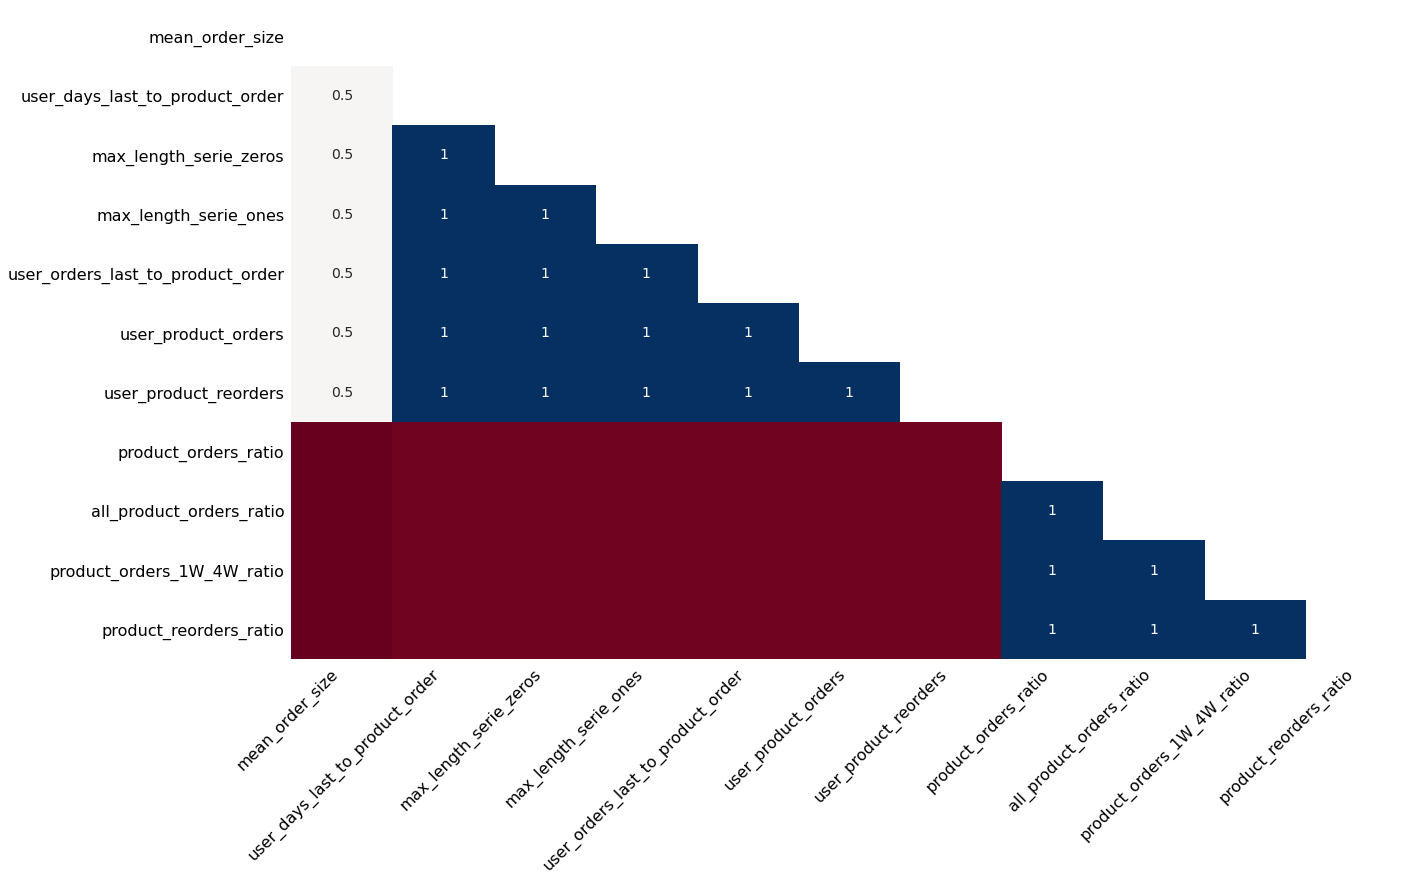

In [37]:
# смотрим в одних и тех же ли признаках у нас NaNы 
# благодяря визуализации нашли NaNы в users_two_one_ratio 
# в результате деления 0 на 0, которые мы заполнили выше
msno.heatmap(df)

In [38]:
# создаем dataframe с тестовыми данными
df = df.reset_index(level='date')
df_test = df[df.date.between('2021','2023')].copy()
df_test.sort_values(by=['cart','date', 'user_id'], inplace = True)
# rolling.sum() и cumsum() считают значения по порядку, несмотря на одинаковое время,
# которое было создано для генерации признаков для тестовых данных
# правильные значения признаков, созданных таким образом, - у первого объекта
# записываем правильные значения всем объектам
count_sum_time_cols = list(df.iloc[:, -5:].columns)
df_test[count_sum_time_cols] = df_test.groupby('cart')[count_sum_time_cols].transform('first')

In [39]:
# проверяем наличие NaNов
# при удлении данных с 2014 по 2019 в тестовых данных появились NaNы
df_test.isna().sum()

date                                 0
user_id                              0
cart                                 0
y                                    0
mean_order_size                      0
user_days_last_to_product_order      0
max_length_serie_zeros               0
max_length_serie_ones                0
user_orders_last_to_product_order    0
orders                               0
order_num                            0
user_product_orders                  0
user_product_reorders                0
users_one_order                      0
users_two_order                      0
product_orders_ratio                 0
all_product_orders_ratio             0
product_orders_1W_4W_ratio           0
product_reorders_ratio               0
users_two_one_ratio                  0
dtype: int64

In [40]:
# удаляем объекты с NaN и тестовые данные 
df = df.dropna()
df = df.drop(df[df.date.between('2021','2023')].index)

In [41]:
# посмотрим на наши признаки, которые мы нагенерировали
#print_data_plots(df)

In [43]:
# определяем обучающие данные
df.sort_values(by=['date'], inplace = True)
X_train = df[df.columns.difference(['user_id','cart', 'order_num','date','y'])]
y_train = df.y

In [43]:
df.head(6)

date  user_id  cart  y  mean_order_size  \
9395454  2015-07-04 14:05:22        3   399  1         1.000000   
9395455  2015-08-12 10:33:44        3   399  0         1.000000   
5195400  2015-11-27 19:37:17        3   134  0         1.333008   
9395456  2015-11-27 19:37:17        3   399  1         1.333008   
12396539 2015-11-27 19:37:17        3   804  0         1.333008   
1310745  2015-12-14 10:30:14       10    21  0         8.000000   

          user_days_last_to_product_order  max_length_serie_zeros  \
9395454                               0.0                     0.0   
9395455                               0.0                     0.0   
5195400                               0.0                     0.0   
9395456                              39.0                     1.0   
12396539                              0.0                     0.0   
1310745                               0.0                     0.0   

          max_length_serie_ones  user_orders_last_to_product_order  orders  \
9395454                     1.0                                0.0       1   
9395455                     2.0                                0.0       2   
5195400                     1.0                                0.0       3   
9395456                     2.0                                1.0       3   
12396539                    1.0                                0.0       3   
1310745                     1.0                                0.0       1   

          order_num  user_product_orders  user_product_reorders  \
9395454           2                  1.0                    0.0   
9395455           3                  2.0                    1.0   
5195400           4                  1.0                    0.0   
9395456           4                  2.0                    1.0   
12396539          4                  1.0                    0.0   
1310745           2                  1.0                    0.0   

          users_one_order  users_two_order  product_orders_ratio  \
9395454                 1                0                  1.00   
9395455                 1                1                  1.00   
5195400                 1                0                  1.00   
9395456                 1                2                  0.75   
12396539                1                0                  1.00   
1310745                 1                0                  1.00   

          all_product_orders_ratio  product_orders_1W_4W_ratio  \
9395454                   1.000000                         1.0   
9395455                   1.000000                         0.5   
5195400                   1.000000                         1.0   
9395456                   1.333333                         0.0   
12396539                  1.000000                         1.0   
1310745                   1.000000                         1.0   

          product_reorders_ratio  users_two_one_ratio  
9395454                 0.000000                  0.0  
9395455                 0.333333                  1.0  
5195400                 0.000000                  0.0  
9395456                 0.250000                  2.0  
12396539                0.000000                  0.0  
1310745                 0.000000                  0.0

In [44]:
# видим, что у нас дисбаланс классов
df.y.value_counts()

0    9048781
1    2005464
Name: y, dtype: int64

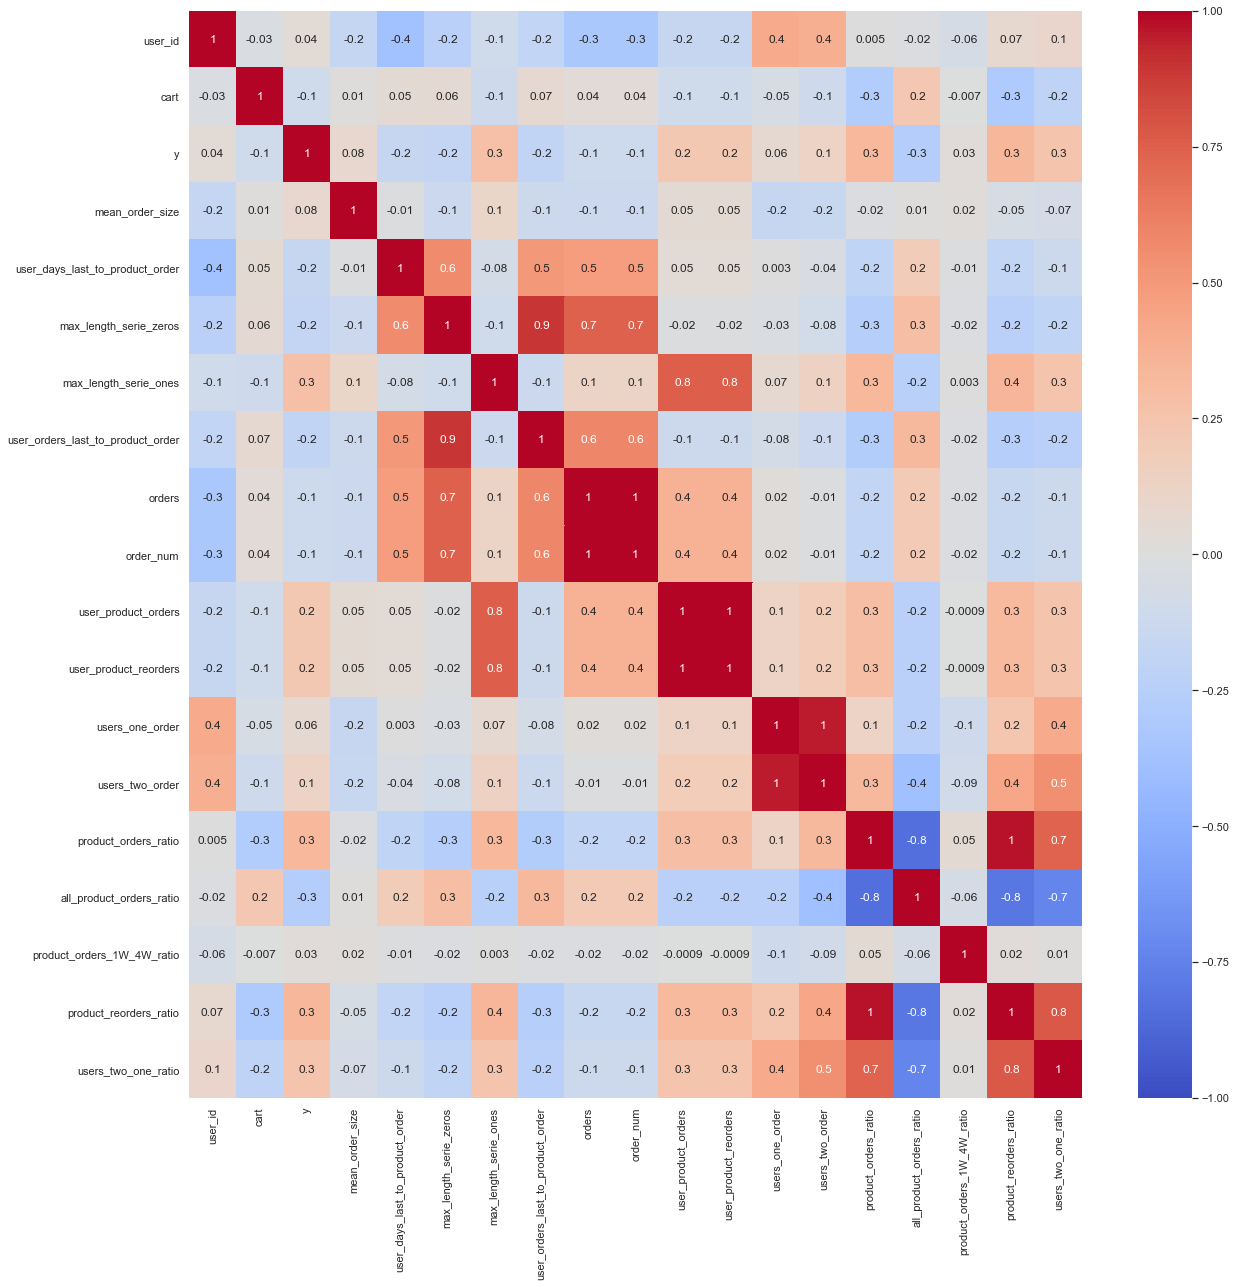

In [45]:
pearson_corr = df.corr(method='pearson') 
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(pearson_corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
plt.show()

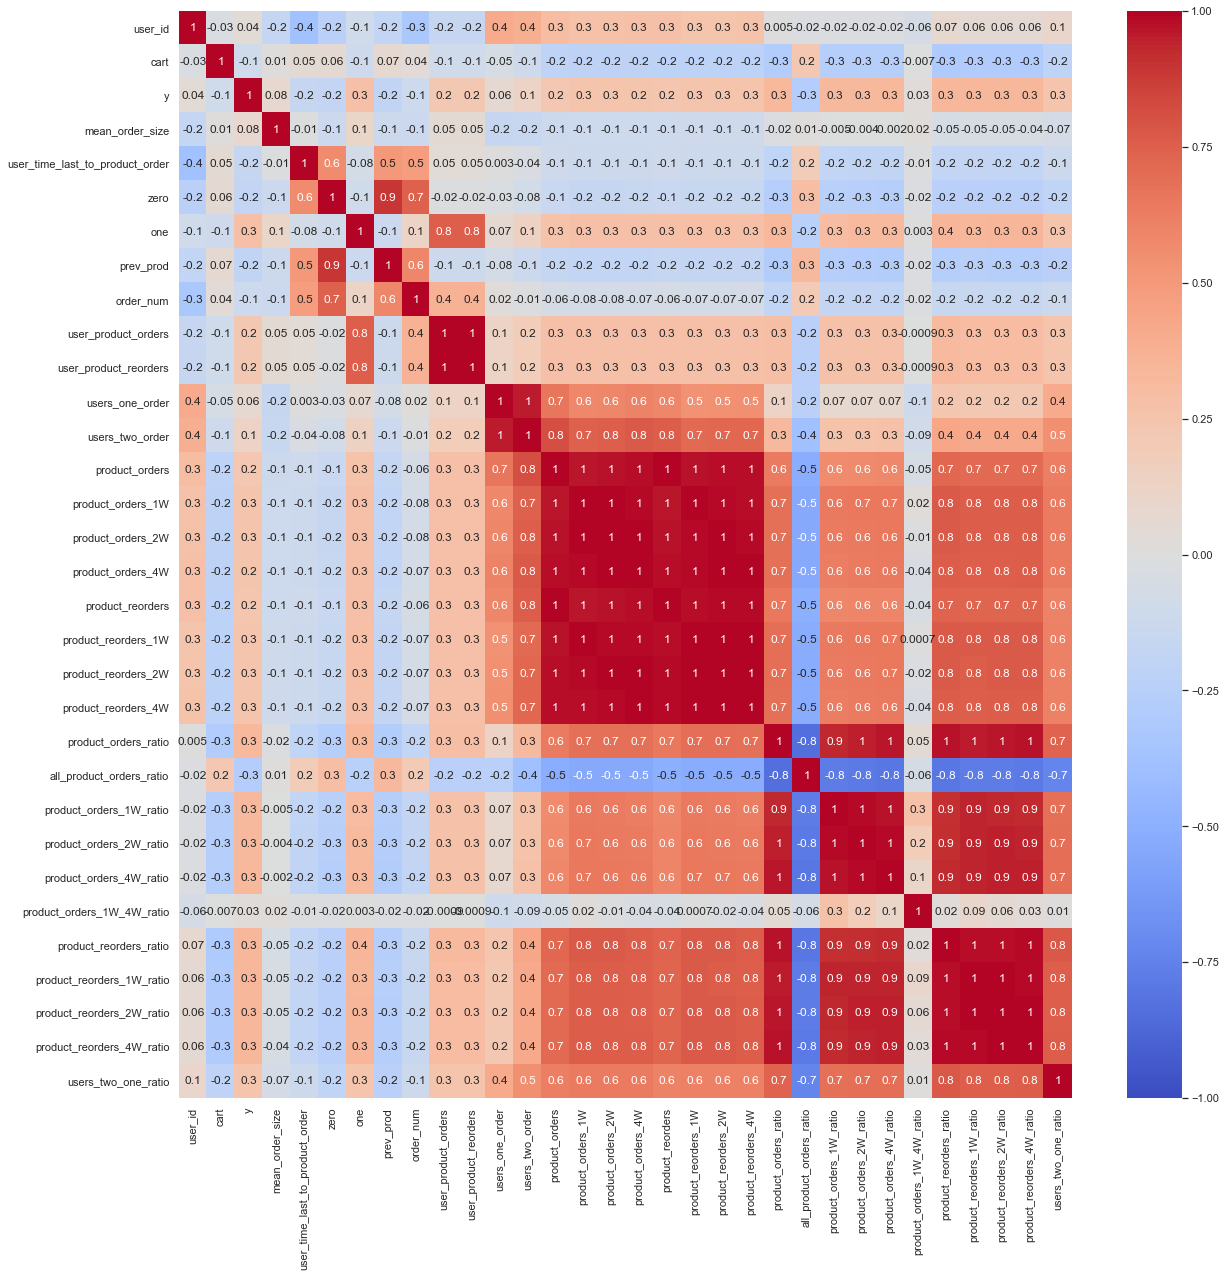

In [55]:
# корреляция признаков со всеми сгенерированными
pearson_corr = df.corr(method='pearson') 
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(pearson_corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
plt.show()

In [ ]:
# сначала я обучил лог. рег. с solver 'saga' и 'liblinear' значения оказались очень близкие по метрикам
# RandomForestClassifier долго обучался и дал значения метрик хуже

In [ ]:
# так как мы обнаружили много коррелирующих признаков
# решили посмотреть с какой комбинацией признаков и регуляризации
# модель обучится лучше
# ниже группы признаков, без которых мы будем обучать модель

dif1 = ['product_orders_2W', 'product_orders_4W', 'product_reorders_1W',
       'product_reorders_4W', 'product_orders_2W_ratio', 'product_orders_4W_ratio',
       'product_reorders_1W_ratio', 'product_reorders_4W_ratio']

dif2 = ['product_orders_2W', 'product_orders_4W', 'product_reorders_1W', 
        'product_reorders_4W', 'product_orders_1W_ratio', 'product_orders_2W_ratio',
        'product_reorders_2W_ratio']

dif3 = ['product_orders_1W', 'product_orders_2W', 'product_orders_4W', 'product_reorders_1W',
        'product_reorders_2W', 'product_reorders_4W']

dif4 = ['product_orders', 'product_orders_1W', 'product_orders_2W', 'product_orders_4W',
        'product_reorders', 'product_reorders_1W', 'product_reorders_2W','product_reorders_4W']

dif5 = ['product_orders_ratio', 'product_orders_1W_ratio', 'product_orders_2W_ratio',
        'product_orders_4W_ratio', 'product_reorders_ratio', 'product_reorders_1W_ratio',
        'product_reorders_2W_ratio', 'product_reorders_4W_ratio']

dif6 = ['product_orders', 'product_orders_1W', 'product_orders_2W', 'product_orders_4W',
        'product_reorders', 'product_reorders_1W', 'product_reorders_2W',
        'product_reorders_4W', 'product_orders_2W_ratio', 'product_orders_4W_ratio',
        'product_reorders_1W_ratio', 'product_reorders_4W_ratio']

dif7 = ['product_orders', 'product_orders_1W', 'product_orders_2W',
        'product_orders_4W', 'product_reorders', 'product_reorders_1W',
        'product_reorders_2W', 'product_reorders_4W', 'product_orders_1W_ratio',
        'product_orders_2W_ratio', 'product_orders_4W_ratio', 'product_reorders_1W_ratio',
        'product_reorders_2W_ratio', 'product_reorders_4W_ratio']

combs  = []
for i in [dif1, dif2, dif3, dif4, dif5, dif6, dif7]:
    combs.append(get_indexes_features(X, X[X.columns.difference(i)]))

In [45]:
SCORING = ['average_precision', 'roc_auc', 'f1']
tscv = TimeSeriesSplit(n_splits = 3)
SEED = 42

In [ ]:
# отбираю коррелирующие признаки
# лучший набор по метрике f1, оказался минимальный по размерам
pipe_col_sel = Pipeline([    
    ('scaler', RobustScaler()),
    ('column_selector', ColumnSelector()),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=500, 
                                      class_weight='balanced', 
                                      solver='saga', n_jobs=-1))])
param_grid_col_sel = {                  
    'classifier__C': [0.01, 0.1, 1],              
    'column_selector__cols': combs               
     }

grid_col_sel = GridSearchCV(pipe_col_sel, param_grid_col_sel, cv=tscv, 
                    scoring=SCORING, refit='average_precision', verbose=2) 

grid_col_sel.fit(X, y)
get_grid_result(grid_col_sel).to_excel('grid_col_sel.xlsx')


In [ ]:
# ищем какой процент выбросов лучше убрать 
pipe_reject = Pipeline([
    ('reject_outliers', FunctionSampler(func=reject_outliers)),
    ('scaler', RobustScaler()),    
    ('classifier', LogisticRegression(random_state=SEED, max_iter=100, 
                                      class_weight='balanced', solver='liblinear'))
    ])

params_reject = {               
    'reject_outliers__kw_args': ([{'contamination': con} for con in [0.00, 0.01, 
                                                                     0.02, 0.03, 0.04]])            
     }

grid_reject = GridSearchCV(pipe_reject, param_reject, cv=tscv, 
                    scoring=SCORING, refit='average_precision', verbose=2) 
grid_reject.fit(X, y)
get_grid_result(grid_reject).to_excel('grid__reject.xlsx')

In [108]:
# после тюнинга логрегрессия на kaggle дала 0.48237, а без 0.47149
pd.read_excel('log_reg_tuning.xlsx', index_col=0)  
# таблица с порядком тюнинга и полученными значениями

# уже после отпарвки ноутбука как ответа на соревнование:
# из-за того, что торопился быстрее отпарвить допустил пару ошибок
# где время, неправильно расположены solvers
# должно быть так
# 141 newton-cg
# 45 lbfgs
# 38 liblinear
# 54 saga

# значения округлялись, где 00
# все подбиралось уже без датасете без отброшенных признаков
# начиная с 2 шага, подбор гиперпараметров был на полном датасете
# c class_weight='balanced'
# c 3 шага solver='liblinear'
# на 3, 4, 5 шагах тюнинг начинался с одинаковых параметров т. е.
# на 4 и 5 не отбрасывали выбросы, а на 5 не доабвляли регуляризацию

Unnamed: 1         Unnamed: 2   Unnamed: 3  \
optimization order                                                      
1.0                           dataset       full dataset          NaN   
NaN                               NaN  without 2014-2019          NaN   
2.0                           solvers            solvers  time in sec   
NaN                               NaN          liblinear          141   
NaN                               NaN          newton-cg           45   
NaN                               NaN               saga           38   
NaN                               NaN              lbfgs           54   
3.0                   reject outliers    contamination %          NaN   
NaN                               NaN                  0          NaN   
NaN                               NaN                  1          NaN   
NaN                               NaN                  2          NaN   
NaN                               NaN                  3          NaN   
NaN                               NaN                  4          NaN   
4.0                    regularization                  С      penalty   
NaN                               NaN              0.001           l2   
NaN                               NaN               0.01           l1   
NaN                               NaN              0.001           l1   
NaN                               NaN               0.01           l2   
NaN                               NaN                0.1           l1   
NaN                               NaN                  1           l1   
NaN                               NaN                0.1           l2   
NaN                               NaN                  1           l2   
5.0                  pos class weight   scale_pos_weight          NaN   
NaN                               NaN                  1          NaN   
NaN                               NaN                  2          NaN   
NaN                               NaN                  3          NaN   
NaN                               NaN                  4          NaN   
NaN                               NaN                  6          NaN   
NaN                               NaN                  8          NaN   
NaN                               NaN                 12          NaN   
NaN                               NaN                 16          NaN   
NaN                               NaN                 24          NaN   
NaN                               NaN                 32          NaN   

                      mean f1  
optimization order             
1.0                  0.480300  
NaN                  0.474800  
2.0                       NaN  
NaN                  0.480345  
NaN                  0.480341  
NaN                  0.480341  
NaN                  0.480337  
3.0                       NaN  
NaN                  0.480300  
NaN                  0.480900  
NaN                  0.481000  
NaN                  0.481100  
NaN                  0.481200  
4.0                       NaN  
NaN                  0.480427  
NaN                  0.480335  
NaN                  0.480285  
NaN                  0.480357  
NaN                  0.480335  
NaN                  0.480347  
NaN                  0.480342  
NaN                  0.480345  
5.0                       NaN  
NaN                  0.247100  
NaN                  0.433600  
NaN                  0.482300  
NaN                  0.482400  
NaN                  0.449200  
NaN                  0.418800  
NaN                  0.383100  
NaN                  0.363200  
NaN                  0.341200  
NaN                  0.329300

In [51]:
# подбираем гиперпараметры для LGBMClassifier c помощью Optuna
lgbm = LGBMClassifier(n_estimators = 250,random_state=SEED) 

param_lgbm = {
    'learning_rate': optuna.distributions.UniformDistribution(0.005, 0.15),                   
    'num_leaves': optuna.distributions.IntUniformDistribution(7, 80),   
    'lambda_l2': optuna.distributions.IntUniformDistribution(0, 12),
    'min_data_in_leaf': optuna.distributions.IntUniformDistribution(20, 1500),
    'subsample': optuna.distributions.UniformDistribution(0.6 ,1.0),
    'colsample_bytree': optuna.distributions.UniformDistribution(0.6, 1.0),  
    'scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 25) 
    }

%time optuna_search_lgbm = optuna.integration.OptunaSearchCV(lgbm, param_lgbm, n_trials=90, 
                                                             random_state=SEED, n_jobs=-1, 
                                                             cv = tscv, scoring= 'f1')
optuna_search_lgbm.fit(X_train, y_train) 

optuna_search_lgbm.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_LGBM2.xlsx")
optuna_search_lgbm.best_params_

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


Wall time: 18 ms


Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
[I 2021-09-23 03:36:49,622] A new study created in memory with name: no-name-6ced4051-6f53-4a32-a021-8b6566a93d92
[I 2021-09-23 03:46:13,827] Trial 1 finished with value: 0.35335137797142574 and parameters: {'learning_rate': 0.09530991565889249, 'num_leaves': 8, 'lambda_l2': 0, 'min_data_in_leaf': 117, 'subsample': 0.9703690741483675, 'colsample_bytree': 0.7264134365421613, 'scale_pos_weight': 21}. Best is trial 1 with value: 0.35335137797142574.
[I 2021-09-23 03:49:14,654] Trial 6 finished with value: 0.3435324571777367 and parameters: {'learning_rate': 0.08420421607050112, 'num_leaves': 12, 'lambda_l2': 11, 'min_data_in_leaf': 726, 'subsample': 0.9706965464707561, 'colsample_bytree': 0.6792442339542665, 'scale_pos_weight': 25}. Best is trial 1 with value: 0.35335137797142574.
[I 2021-09-23 03:55:20,915] Trial 4 finished with value: 0.3641024519910425 and parameters: {

[I 2021-09-23 05:13:03,498] Trial 25 finished with value: 0.46008640754879265 and parameters: {'learning_rate': 0.04536090341705323, 'num_leaves': 38, 'lambda_l2': 9, 'min_data_in_leaf': 1239, 'subsample': 0.8454929288837828, 'colsample_bytree': 0.8637432389912054, 'scale_pos_weight': 6}. Best is trial 9 with value: 0.4905556797774358.
[I 2021-09-23 05:18:56,133] Trial 22 finished with value: 0.35278539620407295 and parameters: {'learning_rate': 0.13157099076898543, 'num_leaves': 71, 'lambda_l2': 7, 'min_data_in_leaf': 1479, 'subsample': 0.8999641639171266, 'colsample_bytree': 0.8501936062886576, 'scale_pos_weight': 1}. Best is trial 9 with value: 0.4905556797774358.
[I 2021-09-23 05:21:58,562] Trial 26 finished with value: 0.4603040819879583 and parameters: {'learning_rate': 0.05027651069246736, 'num_leaves': 38, 'lambda_l2': 12, 'min_data_in_leaf': 1210, 'subsample': 0.8551406793698267, 'colsample_bytree': 0.87211032080708, 'scale_pos_weight': 6}. Best is trial 9 with value: 0.490555

[I 2021-09-23 07:04:07,521] Trial 45 finished with value: 0.3836299660922853 and parameters: {'learning_rate': 0.00959666828526631, 'num_leaves': 61, 'lambda_l2': 10, 'min_data_in_leaf': 365, 'subsample': 0.9987327311463294, 'colsample_bytree': 0.7970851784743496, 'scale_pos_weight': 15}. Best is trial 40 with value: 0.4932916275451957.
[I 2021-09-23 07:07:24,819] Trial 46 finished with value: 0.42686920932622563 and parameters: {'learning_rate': 0.005292510085477393, 'num_leaves': 61, 'lambda_l2': 9, 'min_data_in_leaf': 245, 'subsample': 0.9718864730283234, 'colsample_bytree': 0.7407483907362229, 'scale_pos_weight': 13}. Best is trial 40 with value: 0.4932916275451957.
[I 2021-09-23 07:21:16,313] Trial 50 finished with value: 0.3707746254735637 and parameters: {'learning_rate': 0.0267033473907633, 'num_leaves': 59, 'lambda_l2': 4, 'min_data_in_leaf': 259, 'subsample': 0.9610061306851879, 'colsample_bytree': 0.7450472596603901, 'scale_pos_weight': 16}. Best is trial 40 with value: 0.49

[I 2021-09-23 08:56:43,027] Trial 67 finished with value: 0.4970507989845509 and parameters: {'learning_rate': 0.06126209347810402, 'num_leaves': 65, 'lambda_l2': 1, 'min_data_in_leaf': 662, 'subsample': 0.9774005240502462, 'colsample_bytree': 0.6973688371405095, 'scale_pos_weight': 3}. Best is trial 64 with value: 0.4970686950340708.
[I 2021-09-23 09:00:26,711] Trial 72 finished with value: 0.49712477261782323 and parameters: {'learning_rate': 0.07280792119523564, 'num_leaves': 47, 'lambda_l2': 2, 'min_data_in_leaf': 830, 'subsample': 0.8064350328469048, 'colsample_bytree': 0.6281573812285622, 'scale_pos_weight': 3}. Best is trial 72 with value: 0.49712477261782323.
[I 2021-09-23 09:01:32,694] Trial 73 finished with value: 0.4968051450913485 and parameters: {'learning_rate': 0.0716971524865976, 'num_leaves': 43, 'lambda_l2': 0, 'min_data_in_leaf': 823, 'subsample': 0.7636980370668686, 'colsample_bytree': 0.6704226593809968, 'scale_pos_weight': 3}. Best is trial 72 with value: 0.497124

[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2


{'learning_rate': 0.07280792119523564,
 'num_leaves': 47,
 'lambda_l2': 2,
 'min_data_in_leaf': 830,
 'subsample': 0.8064350328469048,
 'colsample_bytree': 0.6281573812285622,
 'scale_pos_weight': 3}

In [54]:
plot_optimization_history(optuna_search_lgbm.study_)

In [62]:
fig = plot_contour(optuna_search_lgbm.study_, params=['learning_rate', 
                                                      'num_leaves',
                                                      'min_data_in_leaf',
                                                      'scale_pos_weight'])    
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000    
)

In [61]:
fig = plot_contour(optuna_search_lgbm.study_, params=['lambda_l2',
                                                      'min_data_in_leaf',
                                                      'subsample',
                                                      'colsample_bytree'])
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000    
)

In [63]:
plot_parallel_coordinate(optuna_search_lgbm.study_, params=['learning_rate',
                                                            'num_leaves',
                                                            'min_data_in_leaf',
                                                            'scale_pos_weight'])

In [ ]:
tscv = TimeSeriesSplit(n_splits = 5)

In [66]:
# так как значения f1 при обучении бустинга с разными комбинцами 
# гиперпараметров были очень близки  
# я выбрал 3 комбинации гиперпараметров lgbm, достаточно отличающиеся
# по значениям гиперпараметров, c одними из лучших значениями f1
# посмотрел насколько отличаются значения по фолдам при 5-кратной
# кросс-валидации и среднее значение
lgbm = LGBMClassifier(n_estimators=250,random_state=SEED) 
parameter = {'learning_rate': 0.07280792119523564,
             'num_leaves': 47,
             'lambda_l2': 2,
             'min_data_in_leaf': 830,
             'subsample': 0.8064350328469048,
             'colsample_bytree': 0.6281573812285622,
             'scale_pos_weight': 3}
lgbm.set_params(**parameter)
cross_validate(lgbm, X_train, y_train, cv=tscv, scoring = SCORING, n_jobs=-1)

{'fit_time': array([100.33743906, 180.2231133 , 295.06375194, 370.42195868,
        439.66727281]),
 'score_time': array([159.3356657 , 156.80887747, 139.85030627, 125.88000154,
        110.79386997]),
 'test_average_precision': array([0.50773707, 0.50948619, 0.4707523 , 0.4970347 , 0.49559812]),
 'test_roc_auc': array([0.8007917 , 0.80586095, 0.79769808, 0.80795125, 0.81124746]),
 'test_f1': array([0.50427214, 0.50977653, 0.48165229, 0.49613923, 0.49590012])}

In [68]:
lgbm = LGBMClassifier(n_estimators = 250,random_state=SEED) 
parameter = {'learning_rate': 0.0603729079439222,
             'num_leaves': 47,
             'lambda_l2': 2,
             'min_data_in_leaf': 26,
             'subsample': 0.82152842572861,
             'colsample_bytree': 0.776336419091564,
             'scale_pos_weight': 3}
lgbm.set_params(**parameter)
cross_validate(lgbm, X_train, y_train, cv=tscv, scoring = SCORING, n_jobs=-1)

{'fit_time': array([115.24022079, 259.2977066 , 357.0475235 , 443.08562732,
        511.38868451]),
 'score_time': array([179.63959551, 162.33997941, 138.34143376, 120.60788608,
        101.05505061]),
 'test_average_precision': array([0.50650312, 0.50899467, 0.47029861, 0.49719428, 0.49532008]),
 'test_roc_auc': array([0.80093541, 0.80563052, 0.79746206, 0.80804043, 0.81116962]),
 'test_f1': array([0.50447174, 0.50933969, 0.48130036, 0.49628694, 0.4960463 ])}

In [69]:
lgbm = LGBMClassifier(n_estimators = 250,random_state=SEED) 
parameter = {'learning_rate': 0.0289458574581736,
             'num_leaves': 51,
             'lambda_l2': 3,
             'min_data_in_leaf': 481,
             'subsample': 0.916523892534386,
             'colsample_bytree': 0.734796695023928,
             'scale_pos_weight': 3}
lgbm.set_params(**parameter)
cross_validate(lgbm, X_train, y_train, cv=tscv, scoring = SCORING, n_jobs=-1)

{'fit_time': array([135.43082142, 259.11706614, 384.34680152, 469.5827086 ,
        552.95999742]),
 'score_time': array([192.08906317, 174.59474826, 149.16915607, 133.20836663,
        107.49511385]),
 'test_average_precision': array([0.50809244, 0.50900116, 0.46949873, 0.49682894, 0.49423787]),
 'test_roc_auc': array([0.80181939, 0.80577594, 0.79712783, 0.80795152, 0.81074779]),
 'test_f1': array([0.50543361, 0.50957129, 0.48079406, 0.49665949, 0.49499125])}

In [104]:
# значения по фолдам и средние значения f1 при разных комбинациях гиперпараметров lgbm
[np.mean([0.50427214, 0.50977653, 0.48165229, 0.49613923, 0.49590012]),
np.mean([0.50447174, 0.50933969, 0.48130036, 0.49628694, 0.4960463]),
np.mean([0.50543361, 0.50957129, 0.48079406, 0.49665949, 0.49499125])]


[0.497548062, 0.49748900600000007, 0.49748994]

In [77]:
# тестовые данные
X_test = df_test[df_test.columns.difference(['user_id','cart', 'order_num','date','y'])]
y_test = df_test.y

In [93]:
# обучил lgbm на всем обучающем датасете
# и посмотрел какие будут значения f1 с разными 
# гиперпараметрами для бустинга и для лог рег

lgbm = LGBMClassifier(n_estimators = 250,random_state=SEED) 
parameter = {'learning_rate': 0.07280792119523564,
 'num_leaves': 47,
 'lambda_l2': 2,
 'min_data_in_leaf': 830,
 'subsample': 0.8064350328469048,
 'colsample_bytree': 0.6281573812285622,
 'scale_pos_weight': 3}
lgbm.set_params(**parameter)    

lgbm.fit(X_train, y_train) 
y_pred = lgbm.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2


In [ ]:
pipep = Pipeline([
    ('reject_outliers', FunctionSampler(func=reject_outliers, kw_args = ({'contamination': 0.04}))),
    ('scaler', RobustScaler()),    
    ('classifier', LogisticRegression(random_state=SEED, max_iter=100, 
                                      class_weight = {0: 1, 1: 4}, 
                                      solver='liblinear', C=0.001))
    ])

pipep.fit(X_train, y_train) 
y_pred = pipep.predict(X_test)

In [84]:
f1_score(y_test, y_pred, average=None) #logreg

array([0.58267828, 0.37697349])

In [95]:
f1_score(y_test, y_pred, average=None) #1lgbm

array([0.60717218, 0.3124987 ])

In [88]:
f1_score(y_test, y_pred, average=None) #2lgbm

array([0.60740203, 0.31210025])

In [91]:
f1_score(y_test, y_pred, average=None) #3lgbm

array([0.60821093, 0.30960268])

In [96]:
df_test['user_id'] = df_test['user_id'].astype('str')
df_test['cart'] = df_test['cart'].astype('str')
df_test['id'] = df_test[['user_id', 'cart']].agg(';'.join, axis=1)
df_test['target'] = y_pred
df_test['target'] = df_test['target'].astype('int64')
subm = df_test[['id', 'target']]
subm.set_index(['id'], inplace = True)
subm.to_csv('subm_lgbm1.csv')